# C.4. Volatility Skew

## Module: Options

### DRW New-Hire Learning Program

#### Summer 2022

Questions?
* Contact: Mark Hendricks
* hendricks@uchicago.edu

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

import sys
sys.path.insert(0,'../cmds')
from options import *

## Sort Data

In [2]:
LOADFILE = '../data/vol_surfaces.xlsx'

info = pd.read_excel(LOADFILE,sheet_name='descriptions').set_index('specs')
labels = info.columns

lab = labels[0]
raw = pd.read_excel(LOADFILE,sheet_name=lab).set_index('Date')

ts = raw.loc[:,['Future Price','Expiration Future','Expiration Option']]
surf = raw.drop(columns=ts.columns)

indPuts = surf.columns.str.contains('P')
indCalls = surf.columns.str.contains('C')

calls = surf[surf.columns[indCalls]]
puts = surf[surf.columns[indPuts]]

## Try Plotting as Moneyness

In [3]:
Ncutoff = 10

dtgrid = pd.DataFrame([puts.diff().iloc[:-Ncutoff,:].abs().idxmax()[0], ts[['Future Price']].pct_change().abs().iloc[:-Ncutoff,:].idxmax()[0]],columns=['notable date'],index=['max curve shift','max underlying shift'])
for row in dtgrid.index:
    dtgrid.loc[row,'day after'] = puts.loc[dtgrid.loc[row, 'notable date']:,:].index[1]
dtgrid = dtgrid.T
dtgrid

,max curve shift,max underlying shift
notable date,2015-02-25,2014-11-28
day after,2015-02-26,2014-12-01


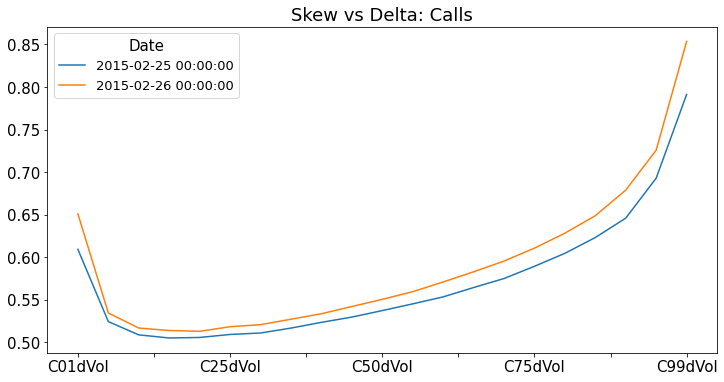

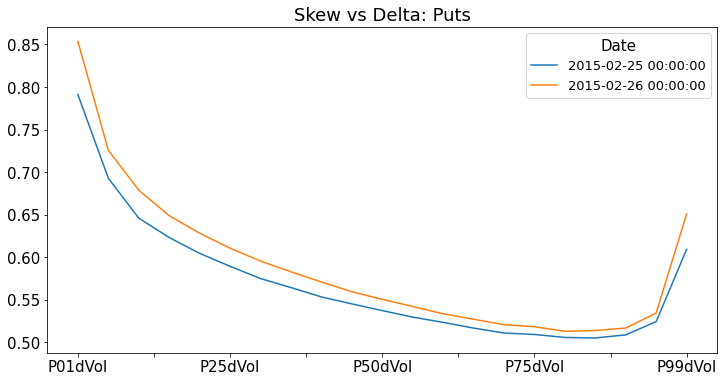

In [4]:
dts = dtgrid.iloc[:,0].values

calls.loc[dts,:].T.plot();
plt.title('Skew vs Delta: Calls')

puts.loc[dts,:].T.plot();
plt.title('Skew vs Delta: Puts')
plt.show()

### We need the Calls reversed!

Though we think of them as increasing delta as **price** goes up, the typical vol skew is graphed against **strike**. And as strike increases, (holding price fixed,) moneyness and delta of the call go down!

Thus, flip the call data (and leave the put data as is.)

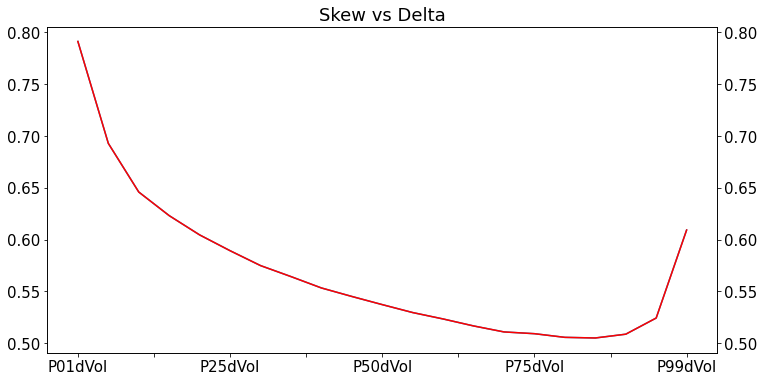

In [5]:
callsSorted = calls.iloc[:,::-1] 

fig, ax = plt.subplots()
dts = dtgrid.iloc[0,0]

callsSorted.loc[dts,:].T.plot(ax=ax);
plt.title('Skew vs Delta')

ax2 = plt.twinx()
puts.loc[dts,:].T.plot(ax=ax2,color='red');

# Contract Examples

In [6]:
info

,NYM CL CL J2015,CME EC EC J2022,CME BP BP U2016,CME ES ES M2020,CBT TY TY U2022,CME ED ED U2022
specs,,,,,,
exchange,NYM,CME,CME,CME,CBT,CME
futures ticker,CL,EC,BP,ES,TY,ED
option ticker,CL,EC,BP,ES,TY,ED
monthYear,J2015,J2022,U2016,M2020,U2022,U2022
option expiration,2015-03-17,2022-04-08,2016-09-09,2020-06-18,2022-08-26,2022-09-19
future expiration,2015-03-20,2022-06-13,2016-09-19,2020-06-19,2022-09-21,2022-09-19


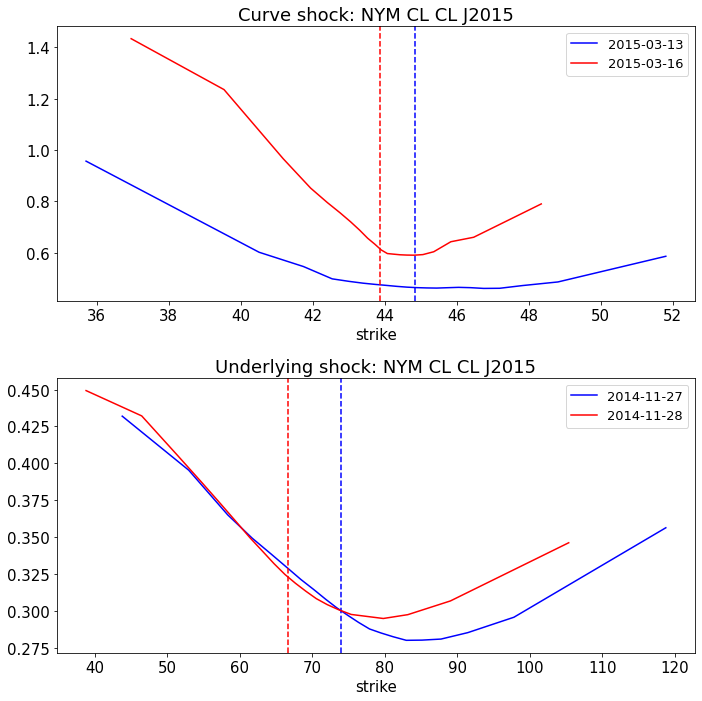

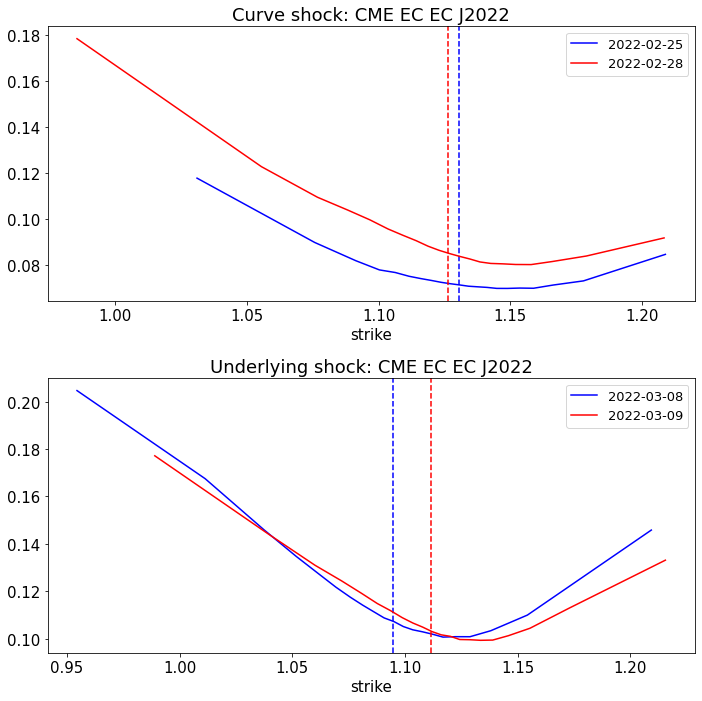

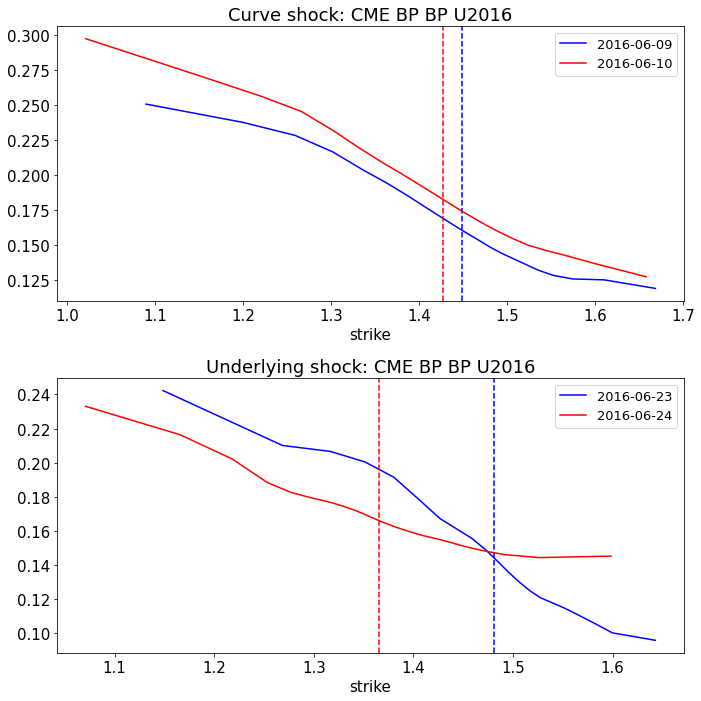

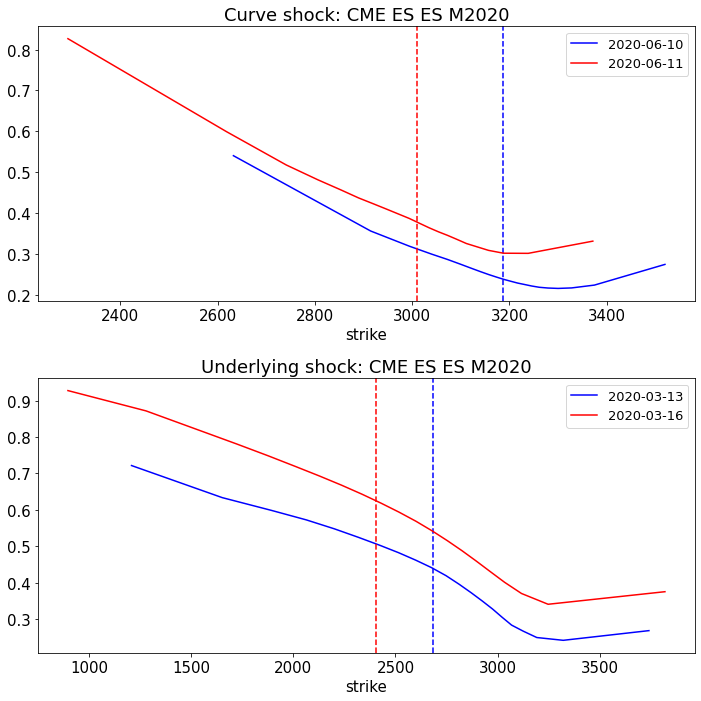

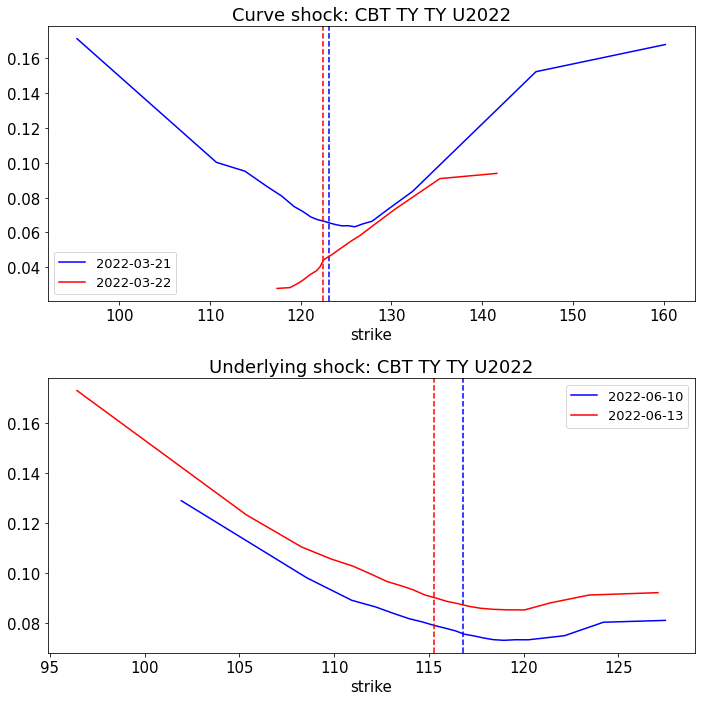

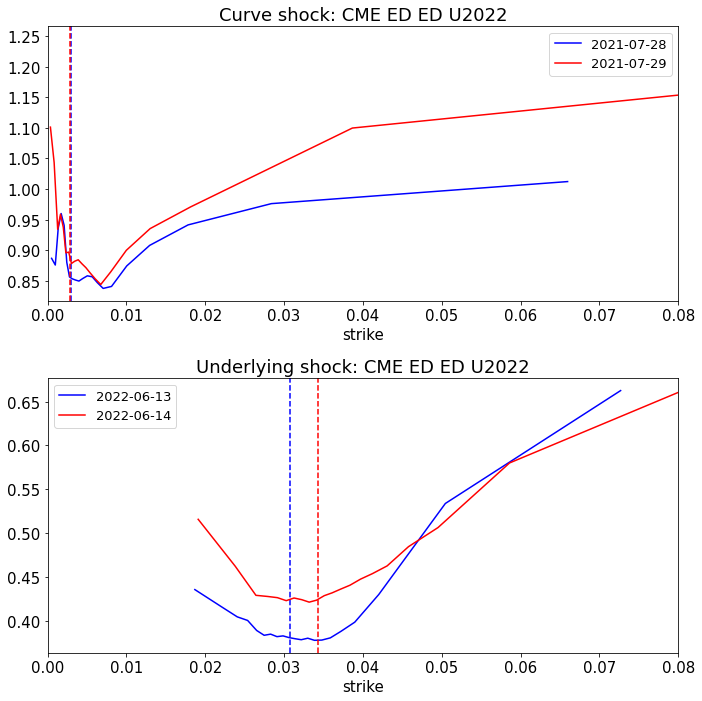

In [7]:
for i, sheet in enumerate(info.columns):

    TYPE = 'put'
        
    ts, opts = load_vol_surface(LOADFILE,sheet)
    
    if info.loc['futures ticker',sheet] == 'ED':
        ts['Future Price'] = 1-ts['Future Price']/100
        dtgrid = get_notable_dates(opts, ts,maxdiff=True)
    else:
        dtgrid = get_notable_dates(opts, ts,maxdiff=False)
        
    strikes = get_strikes_from_vol_moneyness(TYPE,opts,ts)
        
    graph_vol_surface_as_strikes(dtgrid,opts,strikes,ts,info.columns[i])

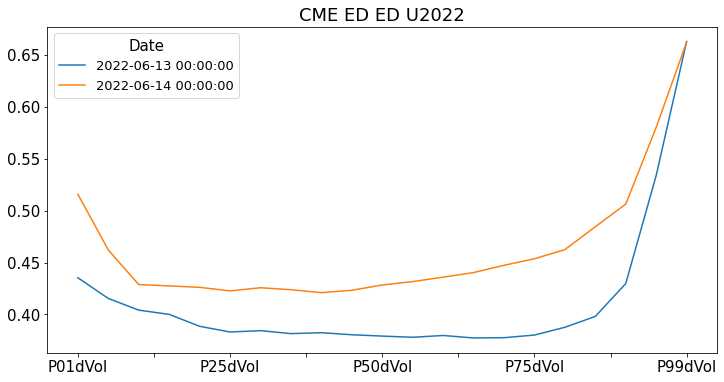

In [8]:
opts.loc[['2022-06-13','2022-06-14']].T.plot(title=info.columns[i]);

# Curve Over Time

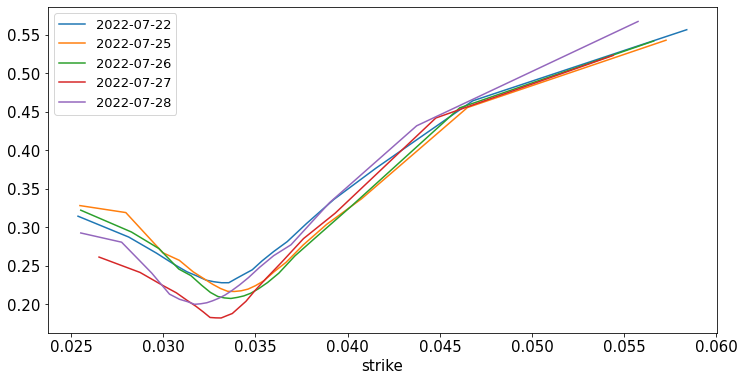

In [9]:
fig, ax = plt.subplots()

for t in opts.index[-5:]:
    plotdata = pd.concat([opts.loc[t,:],strikes.loc[t,:]],axis=1)
    plotdata.columns = [t,'strike']
    plotdata.set_index('strike',inplace=True)
    plotdata.plot(ax=ax)

plt.legend(opts.index[-5:].strftime('%Y-%m-%d'));

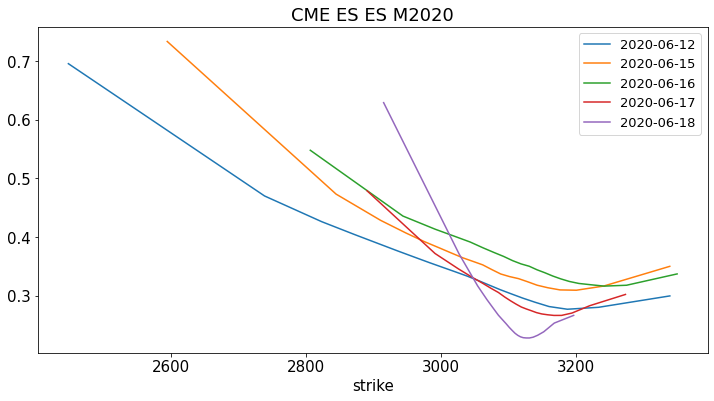

In [12]:
TYPE = 'put'

sheet = info.columns[3]
ts, opts = load_vol_surface(LOADFILE,sheet)

if info.loc['futures ticker',sheet] == 'ED':
    ts['Future Price'] = 1-ts['Future Price']/100
strikes = get_strikes_from_vol_moneyness(TYPE,opts,ts)

fig, ax = plt.subplots()

for t in opts.index[-5:]:
    plotdata = pd.concat([opts.loc[t,:],strikes.loc[t,:]],axis=1)
    plotdata.columns = [t,'strike']
    plotdata.set_index('strike',inplace=True)
    plotdata.plot(ax=ax)

plt.legend(opts.index[-5:].strftime('%Y-%m-%d'));
plt.title(sheet);